## Метод опорных векторов

#### Будем классифицировать несбалансированные 2х-мерные классы:

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=(60,600),cluster_std=0.8, random_state=0)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


Populating the interactive namespace from numpy and matplotlib


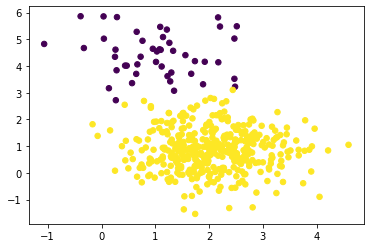

In [2]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30)

#### Настроим SVM-классификаторы с линейным ядром и параметрами регуляризации C=10 и С=0.1(штраф за нарушение).
Так как классы несбалансированы, установим параметр class_weight='balanced'. Для настройки классификатора используем класс sklearn.svm.SVC. 

#### Отобразим на графике обучающую выборку ( pyplot.scatter), добавим разделяющую прямую и опорные вектора.
(для визуализации разделяющей прямой и опорных векторов воспользуемся готовой функцией plot_svc_decision_function)

In [3]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
#        print(model.support_vectors_[:, 0],model.support_vectors_[:, 1])
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, alpha=0.1, c=[0.5,0.5,0.5]);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

#### Посчитаем

Для С=0.1:
    1. число опорных вектров для каждого класса
    2. Зазор M между классами (=1/(2*||w||)
    3. число объектов-нарушителей на обучающей выборке
Для С=10:
    4. число опорных вектров для каждого класса
    5. Зазор M между классами
    6. число объектов-нарушителей на обучающей выборке
    

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


1.C=0.1: число опорных векторов=  39
2.C=0.1: M=1/(2*||w||^2)=0.216
3.C=0.1: число объектов-нарушителей на обучающей выборке = 7
4.C=10.0: число опорных векторов=  7
5.C=10.0: M=1/(2*||w||^2)=0.016
6.C=10.0: число объектов-нарушителей на обучающей выборке = 2


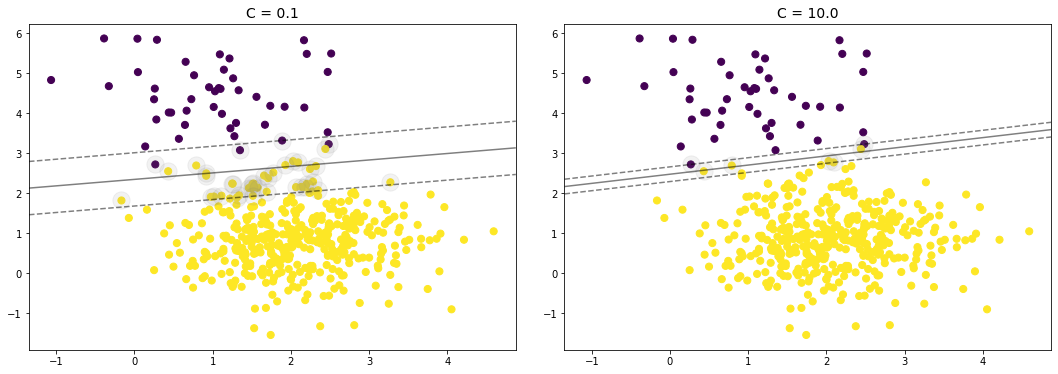

In [4]:
import warnings
warnings.simplefilter("ignore")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
i=1
for axi, C in zip(ax, [ 0.1,10.0]):
    model = SVC(kernel='linear',C=C,class_weight='balanced')
    model.fit(X_train, y_train)
    print(f'{i}.C={C}: число опорных векторов= ',np.sum(model.n_support_))
    i=i+1
    print(f'{i}.C={C}: M=1/(2*||w||^2)={1/(2*(model.coef_**2).sum()):.3f}')
    i=i+1
    y_trpred=model.predict(X_train)
    y_trpred[y_trpred!=y_train]=-100
    print(f'{i}.C={C}: число объектов-нарушителей на обучающей выборке = {len(X_train[y_trpred==-100])}')
    
    axi.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50)
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)
    i=i+1

### Сгенерируем новые 2 класса с нелинейной границей в форме полумесяца:

In [5]:
from sklearn.datasets import make_moons
X, y = make_moons((500,200), noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


### Для этих данных решим задачу классификации с помощью поиска наилучших параметров для алгоритма SVM c ядром.
<img src="images/kernels.jpg" width="400" height="400" />

Сетки значений параметров классификатора для оптимизации:

    - ядра: линейное, rbf,полиномиальное
    - С:[0.1,1, 10](для всех ядер)
    - gamma: [0.01, 0.1,1,10] (для rbf-ядра)
    - degree : [3,5](для полиномиального ядра)
Подбирайте параметры на 5-блочной кросс-валидации, используйте GridSearchCV и sklearn.svm.SVC, так как классы несбалансированы, установите параметр class_weight='balanced'. 


In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'C': [0.1,1, 10], 'kernel': ['linear']},
  {'C': [0.1,1, 10], 'kernel': ['poly'], 'degree' : [3,5]},
  {'C': [0.1,1, 10], 'gamma': [0.01, 0.1,1,10], 'kernel': ['rbf']}
 ]
svc = SVC(probability=True,class_weight='balanced')
clf = GridSearchCV(svc,param_grid,cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', probability=True),
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10], 'degree': [3, 5],
                          'kernel': ['poly']},
                         {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10],
                          'kernel': ['rbf']}])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


лучшие параметры:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


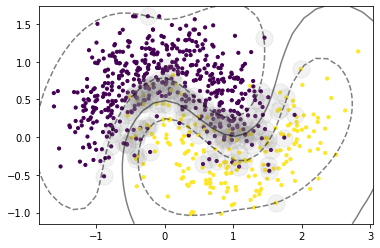

In [8]:
bmodel=clf.best_estimator_
print('лучшие параметры: ',clf.best_params_)
plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
plot_svc_decision_function(bmodel)
plt.scatter(bmodel.support_vectors_[:, 0], bmodel.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');